In [1286]:
### imports ###
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch import optim
import torch.linalg

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import math

import sys
sys.path.append("../neuroprob/")

import neuroprob as mdl
from neuroprob import utils
from neuroprob import GP

import scipy



dev = utils.pytorch.get_device()

plt.style.use(['paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.7.1+cu101
Using device: cuda:0


/homes/dl543/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


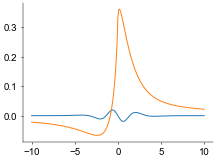

In [1202]:
plt.plot(t_t.numpy(), Kt.numpy()[:, 1, 0])

t = t_t.numpy()
hgh = (np.exp(-t)*scipy.special.expi(t) - np.exp(t)*scipy.special.expi(-t))/np.pi
hgh[hgh != hgh] = 0
hgh += np.exp(-np.abs(t))
plt.plot(t, hgh/3)

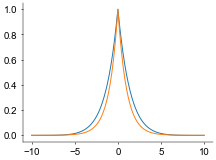

In [2207]:
plt.plot(t_t.numpy(), Kt.numpy()[:, 0, 0])

t = t_t.numpy()
hgh = np.exp(-np.abs(t))
plt.plot(t, hgh)

/homes/dl543/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


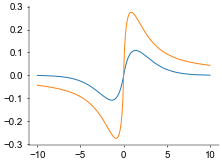

In [2208]:
plt.plot(t_t.numpy(), Kt.numpy()[:, 1, 0])

t = t_t.numpy()
hgh = (np.exp(-t)*scipy.special.expi(t) - np.exp(t)*scipy.special.expi(-t))/np.pi
hgh[hgh != hgh] = 0
plt.plot(t, hgh/1.5)

In [2343]:
T = 30000
trs = 3

# memory
f = torch.randn((trs, T, d))

dt = 0.0002
n = torch.randn((trs, T-1, d)) * np.sqrt(Qc/dt)

for t in range(T-1):
    f[:, t+1, :] = f[:, t, :] + dt*( f[:, t, :] @ F.T + n[:, t, :] @ L.T)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_aspect'

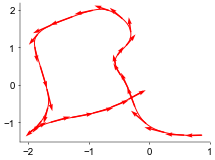

In [2348]:
f_ = f.numpy()
sk = 1000

c = ['r', 'b', 'g']
for tr in [0, 1, 2]:
    xx = f_[tr, :, 0]
    yy = f_[tr, :, d//2]
    plt.plot(xx, yy, color=c[tr])
    idx = np.arange(xx.shape[0])[::sk]
    for i in idx:
        plt.quiver(xx[i], yy[i], xx[i+1]-xx[i], yy[i+1]-yy[i], 
                   scale_units='xy', angles='xy', scale=0.001, color=c[tr])
        
    plt.set_aspect(1.)
    #plt.show()

plt.show()

In [717]:
def create_kernel(kernel_tuples, kern_f, tensor_type):
    """
    Helper function for creating kernel triplet tuple
    """
    track_dims = 0
    kernel = 0

    constrain_dims = ()
    for k, k_tuple in enumerate(kernel_tuples):

        if k_tuple[0] is not None:

            if k_tuple[0] == 'variance':
                krn = GP.kernels.Constant(variance=torch.tensor(k_tuple[1], dtype=tensor_type))

            else:
                kernel_type = k_tuple[0]
                topology = k_tuple[1]
                lengthscales = k_tuple[2]

                if topology == 'sphere':
                    constrain_dims += ((track_dims, len(lengthscales)),)

                act = []
                for _ in lengthscales:
                    act += [track_dims]
                    track_dims += 1

                if kernel_type == 'RBF':
                    krn = GP.kernels.RBF(
                        input_dims=len(lengthscales), \
                        lengthscale=torch.tensor(lengthscales, dtype=tensor_type), \
                        track_dims=act, topology=topology, f=kern_f
                    )
                    
                elif kernel_type == 'tRBF':
                    if topology != 'euclid':
                        raise ValueError('Topology must be euclid')
                    tau_0 = k_tuple[3]
                    kern = GP.kernels.RBF(
                        input_dims=len(lengthscales), \
                        lengthscale=torch.tensor(lengthscales, dtype=tensor_type), \
                        topology=topology, f=kern_f
                    )
                    mapping = time_transform(torch.tensor(tau_0, dtype=tensor_type))
                    krn = GP.kernels.DeepKernel(len(lengthscales), kern, mapping, track_dims=act)
                    
                elif kernel_type == 'DSE':
                    if topology != 'euclid':
                        raise ValueError('Topology must be euclid')
                    lengthscale_beta = k_tuple[3]
                    beta = k_tuple[4]
                    krn = GP.kernels.DSE(
                        input_dims=len(lengthscales), \
                        lengthscale=torch.tensor(lengthscales, dtype=tensor_type), \
                        lengthscale_beta=torch.tensor(lengthscale_beta, dtype=tensor_type), \
                        beta=torch.tensor(beta, dtype=tensor_type), \
                        track_dims=act, f=kern_f
                    )
                    
                elif kernel_type == 'OU':
                    krn = GP.kernels.Exponential(
                        input_dims=len(lengthscales), \
                        lengthscale=torch.tensor(lengthscales, dtype=tensor_type), \
                        track_dims=act, topology=topology, f=kern_f
                    )
                    
                elif kernel_type == 'RQ':
                    scale_mixture = k_tuple[3]
                    krn = GP.kernels.RationalQuadratic(
                        input_dims=len(lengthscales), \
                        lengthscale=torch.tensor(lengthscales, dtype=tensor_type), \
                        scale_mixture=torch.tensor(scale_mixture, dtype=tensor_type), \
                        track_dims=act, topology=topology, f=kern_f
                    )
                    
                elif kernel_type == 'Matern32':
                    krn = GP.kernels.Matern32(
                        input_dims=len(lengthscales), \
                        lengthscale=torch.tensor(lengthscales, dtype=tensor_type), \
                        track_dims=act, topology=topology, f=kern_f
                    )
                    
                elif kernel_type == 'Matern52':
                    krn = GP.kernels.Matern52(
                        input_dims=len(lengthscales), \
                        lengthscale=torch.tensor(lengthscales, dtype=tensor_type), \
                        track_dims=act, topology=topology, f=kern_f
                    )
                    
                elif kernel_type == 'linear':
                    if topology != 'euclid':
                        raise ValueError('Topology must be euclid')
                    krn = GP.kernels.Linear(
                        input_dims=len(lengthscales), \
                        track_dims=act, f=kern_f
                    )
                    
                elif kernel_type == 'polynomial':
                    if topology != 'euclid':
                        raise ValueError('Topology must be euclid')
                    degree = k_tuple[3]
                    krn = GP.kernels.Polynomial(
                        input_dims=len(lengthscales), \
                        bias=torch.tensor(lengthscales, dtype=tensor_type), \
                        degree=degree, track_dims=act, f=kern_f
                    )
                    
                else:
                    raise NotImplementedError('Kernel type is not supported.')

            kernel = GP.kernels.Product(kernel, krn) if kernel != 0 else krn

        else:
            track_dims += 1

    return kernel, track_dims, constrain_dims

### Variability

In [101]:
Tl = 1000
sample_bin = 0.001


l = sample_bin*np.array([30.0])[None, :]
dn = l.shape[1]
v = np.ones(dn)



# generate GP trajectories
kernel_tuples = [('variance', v), 
                 ('RBF', 'euclid', l)]

with torch.no_grad():
    kernel, _, _ = create_kernel(kernel_tuples, 'softplus', torch.double)

    inp = torch.arange(Tl)[None, None, :, None]*sample_bin
    K = kernel(inp, inp)[0, ...]
    K.view(dn, -1)[:, ::Tl+1] += 1e-6


L = torch.cholesky(K)
xi = np.random.randn(dn, Tl)
x = (L * xi[:, None, :]).sum(-1)



# linear Poisson model
neurons = 100
w_len = dn
GPFA = mdl.parametrics.GLM(w_len, neurons, w_len, 'exp', bias=True)

w = np.random.randn(neurons, w_len)
bias = np.random.randn(neurons)
GPFA.set_params(w, bias)


likelihood = mdl.likelihoods.Poisson(sample_bin, neurons, 'exp')
#likelihood.set_Y(rc_t, batch_size=5000, filter_len=1) 

In [102]:
# sample from generative moel
trials = 1
ll_samples = 10

XZ = x.T[None, ...].float() # MC, T, D
F_mu, F_var = GPFA.compute_F(XZ) 
rate = likelihood.sample_rate(F_mu, F_var, trials, ll_samples) # MC, trials, neuron, time
#h = mdl.inference.sample_F(vm_rate, likelihood, [hd_t], 10, list(range(neurons)))

rate = rate.mean(0).numpy()
syn_train = likelihood.sample(rate, XZ=XZ)

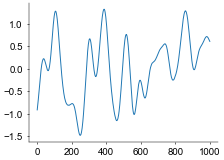

In [103]:
plt.plot(x.numpy()[0, :])

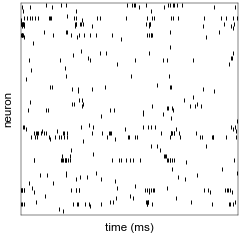

In [174]:
fig, ax = plt.subplots(figsize=(4,4))
utils.plot.raster_plot((fig, ax), syn_train[0, ...], Tl, sample_bin*1000, neurons, markersize=10)
utils.plot.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')


In [124]:
# variability measures
XZ.shape

torch.Size([1, 1000, 2])

In [106]:
t = torch.linspace(0, 10., 100)

K = torch.cos(t[:, None] - t[None, :])
K.view(-1)[::K.shape[0]+1] += 1e-5
L = torch.cholesky(K)

In [111]:
v = L @ torch.randn(100)

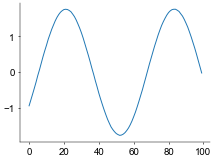

In [112]:
plt.plot(v.numpy())

In [154]:
import scipy

Delta = np.linspace(0.001, 10., 100)
lamb = 1.
K = 200
kk = np.arange(K)[:, None]

gg = (lamb*Delta[None, :])**kk / scipy.special.factorial(kk) * scipy.special.gammaln(kk+1)

y = np.exp(-lamb*Delta) / Delta * gg.sum(0)

Text(0.5, 0, '$\\Delta$ (s)')

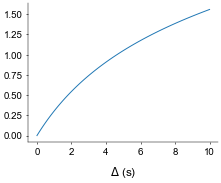

In [157]:
plt.plot(Delta, y)
plt.xlabel(r'$\Delta$ (s)')

### Autograd

In [ ]:
class LegendrePolynomial3(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return grad_output * 1.5 * (5 * input ** 2 - 1)


dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0")  # Uncomment this to run on GPU

# Create Tensors to hold input and outputs.
# By default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass.
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Create random Tensors for weights. For this example, we need
# 4 weights: y = a + b * P3(c + d * x), these weights need to be initialized
# not too far from the correct result to ensure convergence.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
a = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
b = torch.full((), -1.0, device=device, dtype=dtype, requires_grad=True)
c = torch.full((), 0.0, device=device, dtype=dtype, requires_grad=True)
d = torch.full((), 0.3, device=device, dtype=dtype, requires_grad=True)

learning_rate = 5e-6
for t in range(2000):
    # To apply our Function, we use Function.apply method. We alias this as 'P3'.
    P3 = LegendrePolynomial3.apply

    # Forward pass: compute predicted y using operations; we compute
    # P3 using our custom autograd operation.
    y_pred = a + b * P3(c + d * x)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass.
    loss.backward()

    # Update weights using gradient descent
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print(f'Result: y = {a.item()} + {b.item()} * P3({c.item()} + {d.item()} x)')

In [ ]:
# autograd mvm versus direct BP

In [188]:
# autograd of chebyshev

tensor([0.8575, 0.5818, 0.8549, 0.5982, 0.4018, 0.0604, 0.1351, 0.3295, 0.3640,
        0.9148])

In [189]:
def Neumann_SD(A, x, SD_max=100, desired_prec=1e-6):
    res = x
    for s in range(SD_max):
        v = A.mvm(v)
        res = res + v
        if torch.abs(v).max() < desired_prec:
            break
        
    return res

In [402]:
Tl = 30
sample_bin = 0.001

dn = 1

l = 1000.*sample_bin*np.ones((dn, 1))
v = np.ones(dn)

kernel_tuples = [('variance', v), 
                 ('RBF', 'torus_geodesic', l)]

with torch.no_grad():
    kernel, _, _ = GP.kernels.create_kernel(kernel_tuples, 'softplus', torch.float)

    T = torch.linspace(0, 2*np.pi, Tl+1)[:-1]#torch.arange(Tl)*sample_bin
    inp = T[None, None, :, None]
    K = kernel(inp, inp)[0]
    K.view(-1)[::Tl**2+1] += 0e-2
    #K /= K[0, 0, :].sum()
    

    
kernel_tuples = [('variance', v), 
                 ('RBF', 'euclid', l)]

with torch.no_grad():
    kernel, _, _ = GP.kernels.create_kernel(kernel_tuples, 'softplus', torch.float)

    T = torch.linspace(-np.pi, np.pi, Tl+1)[:-1]
    inp = T[None, None, :, None]
    Ke = kernel(inp, inp)[0]
    Ke.view(-1)[::Tl**2+1] += 0e-2
    #K /= K[0, 0, :].sum()
    
    
    
Km = GP.linalg.general_matrix(K, ())
Kmst = GP.linalg.sym_Toeplitz_matrix(K[:, 0, :], ())
Kmc = GP.linalg.circulant_matrix(K[:, 0, :], ())

eigs = torch.eig(Km.explicit()[0, ...])[0][:, 0]
kappa = eigs.max()/eigs.min()
print(kappa)

tensor(-30.4203)


In [403]:
K[0, :6, :6]

tensor([[1.0000, 0.9783, 0.9160, 0.8209, 0.7040, 0.5779],
        [0.9783, 1.0000, 0.9783, 0.9160, 0.8209, 0.7040],
        [0.9160, 0.9783, 1.0000, 0.9783, 0.9160, 0.8209],
        [0.8209, 0.9160, 0.9783, 1.0000, 0.9783, 0.9160],
        [0.7040, 0.8209, 0.9160, 0.9783, 1.0000, 0.9783],
        [0.5779, 0.7040, 0.8209, 0.9160, 0.9783, 1.0000]])

In [404]:
Ke[0, :6, :6]

tensor([[1.0000, 0.9783, 0.9160, 0.8209, 0.7040, 0.5779],
        [0.9783, 1.0000, 0.9783, 0.9160, 0.8209, 0.7040],
        [0.9160, 0.9783, 1.0000, 0.9783, 0.9160, 0.8209],
        [0.8209, 0.9160, 0.9783, 1.0000, 0.9783, 0.9160],
        [0.7040, 0.8209, 0.9160, 0.9783, 1.0000, 0.9783],
        [0.5779, 0.7040, 0.8209, 0.9160, 0.9783, 1.0000]])

tensor(14.4434)
tensor(-1.0954)


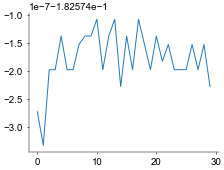

tensor(5.0832)
tensor(1.2574)


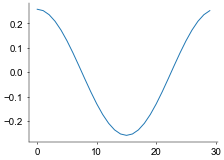

tensor(5.0832)
tensor(0.8239)


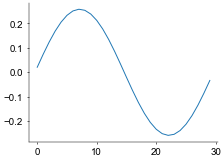

tensor(3.0529)
tensor(-0.5905)


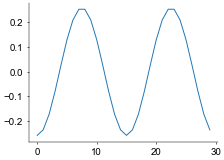

tensor(3.0529)
tensor(0.9553)


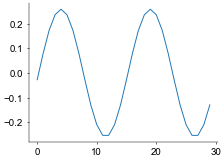

tensor(-0.4748)
tensor(4.7684e-07)


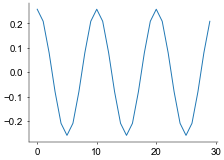

tensor(-0.4748)
tensor(-0.7619)


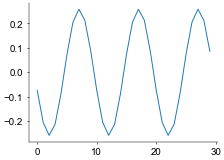

tensor(0.1684)
tensor(-7.1526e-07)


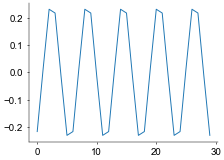

tensor(0.1684)
tensor(5.3644e-07)


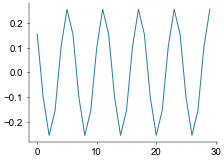

tensor(-0.1075)
tensor(0.2044)


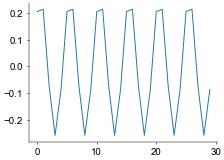

tensor(-0.1075)
tensor(0.1758)


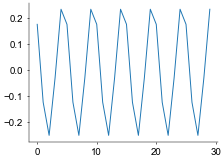

tensor(0.0640)
tensor(-0.1872)


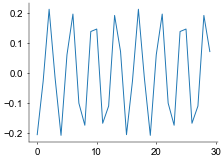

tensor(0.0640)
tensor(0.1395)


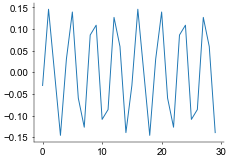

tensor(0.0378)
tensor(0.0496)


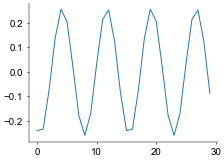

tensor(0.0378)
tensor(-0.3065)


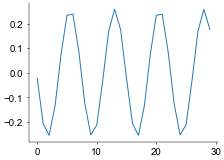

tensor(0.0269)
tensor(0.1488)


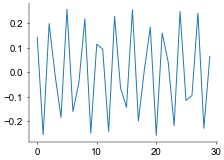

tensor(0.0269)
tensor(-0.1077)


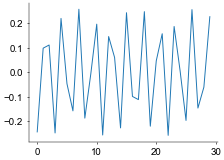

tensor(-0.0324)
tensor(-0.0503)


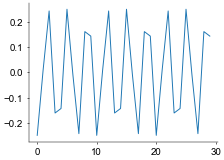

tensor(-0.0324)
tensor(-0.0810)


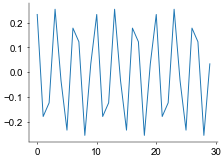

tensor(0.0071)
tensor(0.0932)


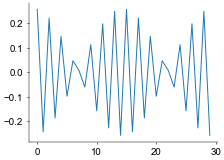

tensor(0.0071)
tensor(0.1275)


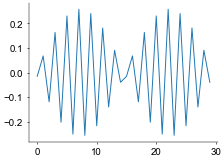

tensor(-0.0044)
tensor(7.3612e-06)


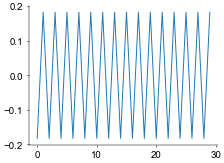

tensor(-0.0059)
tensor(0.2494)


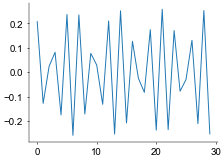

tensor(-0.0059)
tensor(0.1845)


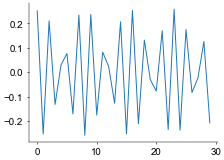

tensor(-0.0100)
tensor(-0.2582)


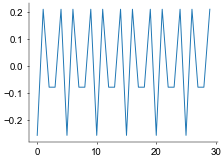

tensor(-0.0148)
tensor(-0.2791)


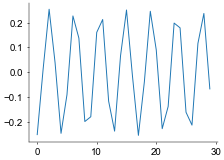

tensor(-0.0148)
tensor(0.0464)


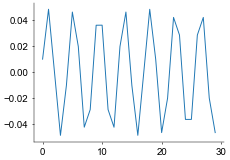

tensor(-0.0144)
tensor(3.6117e-05)


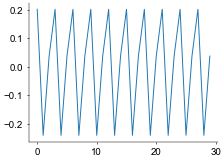

tensor(-0.0144)
tensor(-7.6130e-05)


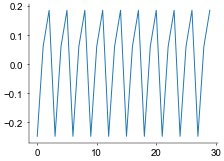

tensor(-0.0100)
tensor(0.2550)


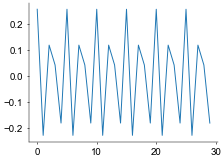

In [405]:
n_e = 0
v = torch.ones(Tl)
v[6:] = 0
L, V = torch.eig(K[0, ...], eigenvectors=True)
for n_e in range(Tl):
    print(L[n_e][0])
    print((V[:, n_e]*v).sum())
    plt.plot(V[:, n_e].numpy())
    #plt.ylim(0)
    plt.show()

In [332]:
v = torch.randn(1, 2, K.shape[-1])
v[..., 5:] = 0.
r = (Km()[:, None, ...] * v[..., None, :]).sum(-1)
r_ = Km.mvm(r)
r__ = Kmc.mvm(v, p=0.5)
r___ = Kmc.mvm(r__, p=0.5)

In [333]:
r__[..., :5]

tensor([[[-0.2414, -0.5968, -0.4174,  0.2291,  0.4338],
         [ 0.1073, -0.1103, -0.3311, -0.9786, -1.1669]]])

In [327]:
print(((r-r___)**2).sum())

tensor(8.7325e-13)


In [174]:
r.sum()

tensor(-2.4660e+08)

In [372]:
a = torch.zeros(Tl)
a[:10] = torch.randn(Tl)
plt.plot(np.real(torch.fft.rfft(a).numpy()))
plt.plot(np.imag(torch.fft.rfft(a).numpy()))

RuntimeError: The expanded size of the tensor (6) must match the existing size (16) at non-singleton dimension 0.  Target sizes: [6].  Tensor sizes: [16]

In [251]:
print(((v-r___)**2).sum())

tensor(29655.7589, dtype=torch.float64)


In [252]:
print(((v-r_)**2).sum())

tensor(596514.7119, dtype=torch.float64)


In [377]:
Tl = 100
sample_bin = 0.001

dn = 1

l = 2*sample_bin*np.ones((dn, 1))
v = np.ones(dn)

kernel_tuples = [('variance', v), 
                 ('RBF', 'euclid', l)]


kernel, _, _ = GP.kernels.create_kernel(kernel_tuples, 'softplus', torch.float)

T = torch.arange(Tl)*sample_bin
inp = T[None, None, :, None]
K = kernel(inp, inp)[0]
K.view(-1)[::Tl**2+1] += 0

UBk = 1#K.sum(-1).max(-1)[0]
    
Km = GP.linalg.general_matrix(K/UBk, ())

In [378]:
eigs = torch.eig(Km.explicit()[0, ...])[0][:, 0]
kappa = eigs.max()/eigs.min()
print(kappa)
print(eigs.max())
print(eigs.min())

tensor(-297744.4375, grad_fn=<DivBackward0>)
tensor(5.0038, grad_fn=<MaxBackward1>)
tensor(-1.6806e-05, grad_fn=<MinBackward1>)


In [385]:
L = torch.tril(Km.explicit()[0, ...], diagonal=-1)
D = torch.zeros((100, 100))
D[range(100), range(100)] = 1



omega = 1.9
SSOR = omega/(2-omega) * (D/omega + L) @ D @ (D/omega + L.T)

In [386]:
M = SSOR.inverse() @ Km.explicit()[0, ...]

eigs = torch.eig(M)[0][:, 0]
kappa = eigs.max()/eigs.min()
print(kappa)
print(eigs.max())
print(eigs.min())

tensor(-4136.6260, grad_fn=<DivBackward0>)
tensor(1.0000, grad_fn=<MaxBackward1>)
tensor(-0.0002, grad_fn=<MinBackward1>)


In [213]:
eps = torch.randn(10000, Tl)
with torch.no_grad():
    eps_ = Km.mvm(eps)
    
    
# rejection sampling    
log_pa = -0.5*((eps_*eps_).sum(-1) - (eps*eps).sum(-1))
log_pa -= log_pa.max()

acc = torch.bernoulli(torch.exp(log_pa))

In [214]:
log_pa.min()

tensor(-10.9807)

In [200]:
f = lambda x: np.log(1-x)
cheb_n = 1000
mc = 1000

with torch.no_grad():
    UB = Km.explicit().sum(-1).max() #full_vector().sum(-1) # Toeplitz primary vector
    logdet = GP.linalg.log_det_Chebyshev(Km, UB, mc, f, cheb_n, recursive=True)

In [201]:
log_w = -0.5*((eps_*eps_).sum(-1) - (eps*eps).sum(-1)) + logdet

lm = log_w.max()

qK = (eps * Km.mvm(eps_)).sum(-1)
res = torch.exp(lm) * ( torch.exp(log_w-lm) * qK ).mean(0)

In [202]:
res

tensor(1.6272, grad_fn=<MulBackward0>)

In [203]:
(eps*eps).sum(-1).mean(0)

tensor(5.0062)

In [99]:
qK.shape

torch.Size([1000])

In [68]:
L = torch.cholesky(K)
logdet_chol = 2*torch.log(L[..., np.arange(K.shape[-1]), np.arange(K.shape[-1])]).sum(-1)

print(torch.slogdet(K)[1])
print(logdet_chol)

tensor([-10.2743], grad_fn=<SlogdetBackward>)
tensor([-10.2744], grad_fn=<MulBackward0>)


In [48]:
logdet_chol.backward()

In [51]:
list(kernel.parameters())[0].grad

tensor([4.7438])

In [317]:
B = torch.randn(1, 1, Tl)
Km.tensor = Km.tensor.double()
B = B.double()

In [330]:
X_k = GP.linalg.linear_cg(Km.mvm, B)

CG terminated in 5000 iterations with average residual norm 1.2429861675664265e-06 which is larger than the tolerance of 1e-12 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.


In [334]:
UB = K.sum(-1).max(-1)[0]

X_kn = Neumann(Km, UB, B, n=1000)
print(X_kn)

tensor([[[  -5.4844,  -35.1152,  127.4936, -142.1654,   -8.3591,  176.6158,
          -143.7373,  -69.1143,  225.0925, -188.2023,   51.4914,   44.8072,
           -62.5786,   52.7404,  -63.8373,   70.5471,  -45.9209,   32.3242,
           -76.0690,  146.2642, -169.0760,  130.9046,  -78.3904,   38.5850,
           -13.0697,   -2.8886,   24.5330,  -34.3684,   -2.2584,   40.8205,
            -0.9026, -102.4571,  166.3929, -133.8413,   55.7714,  -24.3292,
            51.0791,  -33.3335,  -91.0863,  214.7423, -178.6866,    1.0623,
           123.5346,  -88.1807,   -5.3401,   11.4811,   84.5000, -179.6997,
           188.8154, -121.5848,   28.4071,   39.1471,  -50.3432,   12.1591,
            43.9970,  -83.2975,   45.1276,   90.2401, -220.6022,  228.4828,
          -140.8502,   83.5866, -103.1851,  112.9546,  -59.9773,   21.2048,
           -69.2939,  159.7532, -175.9011,   58.8071,  116.3398, -187.0064,
            92.8659,   44.0341,  -81.3872,   22.6915,   30.5482,  -38.3547,
            

In [327]:
X_k, cg_info = GP.linalg.cg_batch(Km.mvm, B, M_bmm=None, X0=None, rtol=1e-3, atol=0., maxiter=None, verbose=True, lr=1e-3, resetiter=10)

 it |       dist   it/s
001 | 5.3629e+01 916.61
002 | 5.3602e+01 1950.59
003 | 5.3584e+01 2139.07
004 | 5.3571e+01 2127.88
005 | 5.3560e+01 2200.08
006 | 5.3551e+01 2318.94
007 | 5.3543e+01 2239.39
008 | 5.3537e+01 2218.21
009 | 5.3531e+01 2268.87
010 | 5.3525e+01 2322.34
011 | 5.3472e+01 1985.07
012 | 5.3445e+01 1592.51
013 | 5.3427e+01 2195.97
014 | 5.3414e+01 1778.87
015 | 5.3403e+01 2242.61
016 | 5.3394e+01 2280.36
017 | 5.3386e+01 2324.47
018 | 5.3380e+01 2308.70
019 | 5.3374e+01 2301.60
020 | 5.3368e+01 2358.00
021 | 5.3315e+01 1972.36
022 | 5.3288e+01 2225.44
023 | 5.3271e+01 2274.55
024 | 5.3257e+01 2308.40
025 | 5.3247e+01 2288.66
026 | 5.3238e+01 2308.69
027 | 5.3230e+01 2274.86
028 | 5.3223e+01 2310.35
029 | 5.3218e+01 2345.61
030 | 5.3212e+01 2314.08
031 | 5.3159e+01 2003.32
032 | 5.3132e+01 2299.06
033 | 5.3115e+01 2315.47
034 | 5.3101e+01 2318.46
035 | 5.3091e+01 2333.80
036 | 5.3082e+01 2329.35
037 | 5.3074e+01 2323.87
038 | 5.3068e+01 2258.45
039 | 5.3062e+01 2279.16
04

In [332]:
X_k_ = (Km().inverse()[..., None, :, :] * B[..., None, :]).sum(-1)
print(X_k_)

tensor([[[ 3.1548e+03, -1.9690e+04,  6.3036e+04, -1.4237e+05,  2.5811e+05,
          -4.0161e+05,  5.5743e+05, -7.0705e+05,  8.3341e+05, -9.2497e+05,
           9.7694e+05, -9.8908e+05,  9.6196e+05, -8.9487e+05,  7.8707e+05,
          -6.4155e+05,  4.6836e+05, -2.8494e+05,  1.1281e+05,  2.7756e+04,
          -1.2278e+05,  1.6764e+05, -1.6760e+05,  1.3553e+05, -8.7495e+04,
           3.7912e+04,  3.8622e+03, -3.4422e+04,  5.4840e+04, -6.7924e+04,
           7.5405e+04, -7.6467e+04,  6.8353e+04, -4.8554e+04,  1.7127e+04,
           2.2134e+04, -6.2185e+04,  9.4557e+04, -1.1185e+05,  1.1012e+05,
          -9.0294e+04,  5.7804e+04, -2.0724e+04, -1.2803e+04,  3.6523e+04,
          -4.6923e+04,  4.3572e+04, -2.9475e+04,  1.1137e+04,  2.5907e+03,
          -3.2385e+03, -1.3849e+04,  4.6959e+04, -8.7778e+04,  1.2380e+05,
          -1.4255e+05,  1.3620e+05, -1.0522e+05,  5.9400e+04, -1.5030e+04,
          -1.1443e+04,  1.0418e+04,  1.6650e+04, -5.7666e+04,  9.4383e+04,
          -1.0908e+05,  9

In [335]:
torch.abs(X_k_ - X_kn)

tensor([[[3.1603e+03, 1.9655e+04, 6.2909e+04, 1.4223e+05, 2.5812e+05,
          4.0178e+05, 5.5758e+05, 7.0698e+05, 8.3319e+05, 9.2478e+05,
          9.7689e+05, 9.8912e+05, 9.6203e+05, 8.9492e+05, 7.8713e+05,
          6.4162e+05, 4.6840e+05, 2.8497e+05, 1.1289e+05, 2.7609e+04,
          1.2261e+05, 1.6751e+05, 1.6753e+05, 1.3550e+05, 8.7482e+04,
          3.7914e+04, 3.8377e+03, 3.4387e+04, 5.4843e+04, 6.7964e+04,
          7.5406e+04, 7.6365e+04, 6.8187e+04, 4.8420e+04, 1.7071e+04,
          2.2158e+04, 6.2236e+04, 9.4590e+04, 1.1176e+05, 1.0991e+05,
          9.0116e+04, 5.7803e+04, 2.0847e+04, 1.2715e+04, 3.6528e+04,
          4.6934e+04, 4.3487e+04, 2.9296e+04, 1.0948e+04, 2.7123e+03,
          3.2669e+03, 1.3888e+04, 4.7009e+04, 8.7790e+04, 1.2376e+05,
          1.4246e+05, 1.3615e+05, 1.0531e+05, 5.9621e+04, 1.5258e+04,
          1.1302e+04, 1.0334e+04, 1.6753e+04, 5.7779e+04, 9.4443e+04,
          1.0910e+05, 9.1214e+04, 4.1465e+04, 2.8044e+04, 9.7917e+04,
          1.4826e+05

In [88]:
n = 100
f = lambda x: 1/(1-x)

c = GP.chebyshev.Chebyshev_coeff(f, n)

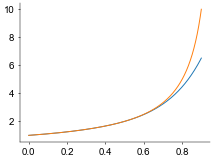

In [90]:
x = np.linspace(0.0, 0.9, 1000)

k = np.arange(0, 10)
yy = (x[:, None]**k[None, :]).sum(-1)

y = GP.chebyshev.eval_Chebyshev(x, c)
plt.plot(x, yy)
plt.plot(x, f(x))
plt.show()

In [313]:
data = np.abs(Km().inverse()[0, ...].numpy())

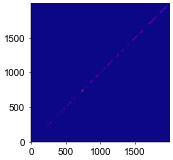

In [314]:
fig, ax = plt.subplots()


im = utils.plot.draw_2d((fig, ax), data, origin='lower', cmap='plasma', vmin=0, vmax=data.max(), aspect='equal')

### TT algebra

In [112]:
batch_shape = (2,)
dim_list = [10]
GR_K = 3
mc = 2

random_G = GP.linalg.sample_Gauss_Rademacher(batch_shape, mc, dim_list, GR_K)

In [113]:
random_G.tensor_list[0]().shape

torch.Size([2, 2, 3, 10])

In [114]:
random_G.trace_i()

tensor([[[ 0.1686,  0.4185, -0.2104,  0.8929,  1.5443,  1.3515,  0.7762,
           1.5989, -0.1184, -1.5548],
         [ 1.3935, -0.5687,  0.8508, -0.3485, -0.2671, -0.7982,  0.7285,
           1.2073,  1.3788, -0.6392]],

        [[ 0.8995,  2.6155,  1.3558,  1.5800, -0.2458,  0.1168, -1.0426,
           1.2135,  1.0616, -1.5230],
         [ 0.0230,  0.1509,  0.9078, -0.0774, -0.9707,  2.4064,  0.0312,
           0.8023, -0.6235,  0.1953]]])

In [115]:
Psi_list = [torch.randn(mc, *batch_shape, 1, dim_list[d]) for d in range(len(dim_list))]
Psi = GP.linalg.TT_vector([GP.linalg.vector(v, (-1,)) for v in Psi_list], 1)

In [116]:
Psi.tensor_list[0]().shape

torch.Size([2, 2, 1, 10])

In [117]:
G = Psi.hadamard_prod(random_G)

In [118]:
G.explicit()

tensor([[[ 0.0942,  0.7279, -0.2490,  1.6154, -2.1319,  0.2715, -0.6625,
          -0.8536, -0.1596, -0.2210],
         [-1.4364, -0.2803,  0.6118,  0.1786,  0.2803,  0.0326, -0.7847,
           1.1806, -0.5361,  0.3398]],

        [[ 1.1520,  0.3872, -0.0137,  0.8303,  0.3593, -0.2124,  0.7760,
          -1.7435,  0.7430, -0.4006],
         [ 0.0109, -0.0558, -0.5135,  0.0254, -0.0193, -1.1249, -0.0399,
          -0.2680, -0.1922,  0.0315]]])

In [119]:
Psi.explicit()*random_G.explicit()

tensor([[[ 0.0942,  0.7279, -0.2490,  1.6154, -2.1319,  0.2715, -0.6625,
          -0.8536, -0.1596, -0.2210],
         [-1.4364, -0.2803,  0.6118,  0.1786,  0.2803,  0.0326, -0.7847,
           1.1806, -0.5361,  0.3398]],

        [[ 1.1520,  0.3872, -0.0137,  0.8303,  0.3593, -0.2124,  0.7760,
          -1.7435,  0.7430, -0.4006],
         [ 0.0109, -0.0558, -0.5135,  0.0254, -0.0193, -1.1249, -0.0399,
          -0.2680, -0.1922,  0.0315]]])

In [129]:
tl = [torch.randn(mc, *batch_shape, 1, dim_list[d]-1) for d in range(len(dim_list))]

tIm = GP.linalg.TT_matrix([GP.linalg.trilI_Toeplitz_matrix(m, (-1,)) for m in tl], 1, 1)

In [130]:
tIm.explicit()[0, 0, ...]

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-2.1967,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-1.1594, -2.1967,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 1.3493, -1.1594, -2.1967,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.4966,  1.3493, -1.1594, -2.1967,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.5829,  0.4966,  1.3493, -1.1594, -2.1967,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.3987, -0.5829,  0.4966,  1.3493, -1.1594, -2.1967,  1.0000,  0.0000,
          0.0000,  0.0000],
        [-1.2676,  0.3987, -0.5829,  0.4966,  1.3493, -1.1594, -2.1967,  1.0000,
          0.0000,  0.0000],
        [-0.7882, -1.2676,  0.3987, -0.5829,  0.4966,  1.3493, -1.1594, -2.1967,
          1.0000,  0.0000],
        [-1.3494, -

In [11]:
ttk.explicit().shape

torch.Size([1, 1, 9, 9])

In [7]:
Tl = 3
sample_bin = 0.001

dn = 1

l = 2.*sample_bin*np.ones((dn, 1))
l_2 = 4.*sample_bin*np.ones((dn, 1))
v = np.ones(dn)

In [10]:

K_list = [GP.kernels.Product(
    GP.kernels.Constant(variance=torch.tensor(v, dtype=torch.float)), 
    GP.kernels.RBF(input_dims=len(l), \
                   lengthscale=torch.tensor(l, dtype=torch.float), \
                   topology='euclid')), 
    GP.kernels.RBF(input_dims=len(l_2), \
                   lengthscale=torch.tensor(l_2, dtype=torch.float), \
                   topology='euclid')
]
track_dims_list = [[0], [1]]

TTk = GP.kernels.KTT_kernel(K_list, track_dims_list)


U_list = [torch.arange(Tl)[None, None, :, None]*sample_bin, 
          torch.arange(Tl)[None, None, :, None]*sample_bin]

ttk = TTk.Kronecker_Toeplitz(U_list)

In [ ]:
f = lambda x: np.log(1-x)
cheb_n = 1000
mc = 10
D = len(ttk.tensor_list)

d_list = np.empty((D,))
for en, tt_ in enumerate(ttk.tensor_list):
    d_list[en] = tt_.n

logdets = []
d_vec = []
for en, tt_ in enumerate(ttk.tensor_list):
    UB = tt_.full_vector().sum(-1) # Toeplitz primary vector
    logdet = GP.linalg.log_det_Chebyshev(tt_, UB, mc, f, cheb_n, recursive=True)
    d_others = np.prod(d_list[np.arange(D) != en])
    logdets.append(d_others*logdet)



In [297]:
torch.stack(logdets).sum(0)

tensor([[[-84.9136]]], grad_fn=<SumBackward1>)

In [202]:
TTk(torch.cat(U_list, dim=-1)).tensor_list[0]()-TTk.X_U_list(torch.cat(U_list, dim=-1), U_list).tensor_list[0]()

tensor([[[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]]],
       grad_fn=<SubBackward0>)

In [78]:
V_list = [GP.linalg.vector(torch.randn(2, Tl)[None, None, ...]*sample_bin, (-1,)), 
          GP.linalg.vector(torch.randn(2, Tl)[None, None, ...]*sample_bin, (-1,))]

ttv = GP.linalg.TT_vector(V_list, 1)

ttv_ = ttk.mvm(ttv)

In [79]:
print(ttv.scalar_prod(ttv_))
print((ttv.explicit()[..., None] * ttk.explicit() * ttv.explicit()[..., None, :]).sum(-1).sum(-1))

tensor([[1.7098e-11]], grad_fn=<SumBackward1>)
tensor([[1.7098e-11]], grad_fn=<SumBackward1>)


In [74]:
ttv.trace_i()

tensor([[8.5963e-12]], grad_fn=<SumBackward1>)

In [374]:
kernel_tuples = [('variance', v), 
                 ('RBF', 'euclid', l), 
                 ('RBF', 'euclid', l_2)]

with torch.no_grad():
    kernel, _, _ = GP.kernels.create_kernel(kernel_tuples, 'softplus', torch.float)

    T = torch.arange(Tl)*sample_bin
    T_2 = torch.arange(Tl)*sample_bin
    grid_1, grid_2 = torch.meshgrid(T, T_2)
    inp = torch.cat((grid_1.flatten()[None, None, :, None], grid_2.flatten()[None, None, :, None]), dim=-1)
    K = kernel(inp, inp)[0, 0]
    K.view(-1)[::Tl**2+1] += 1e-12
    
    
    # Nystrom
    U = torch.arange(Tl)*sample_bin
    grid_1, grid_2 = torch.meshgrid(U, U)
    inp_U = torch.cat((grid_1.flatten()[None, None, :, None], grid_2.flatten()[None, None, :, None]), dim=-1)
    K_1 = kernel(inp, inp_U)[0, 0]
    K_2 = kernel(inp_U, inp)[0, 0]
    K_U = kernel(inp_U, inp_U)[0, 0]
    K_U.view(-1)[::Tl**2+1] += 1e-12

In [378]:
L = torch.cholesky(K[None, None, ...])
logdet_chol = 2*torch.log(L[..., np.arange(K.shape[0]), np.arange(K.shape[0])]).sum(-1)

print(torch.slogdet(K)[1])
print(logdet_chol)

tensor(-35.0937)
tensor([[-35.0935]])


In [377]:
L.shape

torch.Size([1, 1, 9, 9])

In [361]:
((K-K_nys)**2).sum()

tensor(31386784.)

### GPFADS

# GPFA

In [ ]:
import numpy as np
from scipy import stats
#from sklearn.linear_model import LinearRegression()
#model = LinearRegression().fit(n_1, n_2)

a = 0.8
n_1 = []
n_2 = []
for y_1 in np.linspace(80.0, 100.0, 50):
    y_2 = a*y_1
    n_1.append(np.random.poisson(y_1, size=(100,)))
    n_2.append(np.random.poisson(y_2, size=(100,)))
    
n_1 = np.asarray(n_1).reshape(-1)
n_2 = np.asarray(n_2).reshape(-1)

plt.scatter(n_1, n_2, s=1)
x = np.array([60.0, 120.0])
plt.plot(x, a*x, label='truth', c='c')
slope, intercept, r_value, p_value, std_err = stats.linregress(n_1,n_2)
plt.plot(x, x*slope + intercept, 'r--', label='regression')
plt.xlabel(r'$n_1$')
plt.ylabel(r'$n_2$')
plt.legend()
plt.show()

plt.scatter(np.sqrt(n_1), np.sqrt(n_2), s=1)
x = np.array([8.0, 11.0])
plt.plot(x, np.sqrt(a)*x, label='truth', c='c')
slope, intercept, r_value, p_value, std_err = stats.linregress(np.sqrt(n_1),np.sqrt(n_2))
plt.plot(x, x*slope + intercept, 'r--', label='regression')
plt.xlabel(r'$\sqrt{n_1}$')
plt.ylabel(r'$\sqrt{n_2}$')
plt.legend()
plt.show()


from sklearn.decomposition import PCA
d_1 = n_1
d_2 = n_2

X = np.stack([d_1-d_1.mean(), d_2-d_2.mean()]).T
pca = PCA(n_components=2)
pca.fit(X)
V = pca.components_
print(V.shape)
x_pca_axis, y_pca_axis = 2 * V.T
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

plt.scatter(d_1, d_2, s=1)
x = np.array([60.0, 120.0])
plt.plot(x, a*x, label='truth', c='c')
slope = y_pca_axis[0]/x_pca_axis[0]
dx = 30.0
x = [d_1.mean() - dx, d_1.mean() + dx]
y = [d_2.mean() - dx*slope, d_2.mean() + dx*slope]
plt.plot(x, y, 'r--', label='PCA')
plt.xlabel(r'$n_1$')
plt.ylabel(r'$n_2$')
plt.legend()
plt.show()


d_1 = np.sqrt(n_1)
d_2 = np.sqrt(n_2)

X = np.stack([d_1-d_1.mean(), d_2-d_2.mean()]).T
pca = PCA(n_components=2)
pca.fit(X)
V = pca.components_
print(V.shape)
x_pca_axis, y_pca_axis = 2 * V.T
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

plt.scatter(d_1, d_2, s=1)
x = np.array([8.0, 11.0])
plt.plot(x, np.sqrt(a)*x, label='truth', c='c')
slope = y_pca_axis[0]/x_pca_axis[0]
dx = 1.5
x = [d_1.mean() - dx, d_1.mean() + dx]
y = [d_2.mean() - dx*slope, d_2.mean() + dx*slope]
plt.plot(x, y, 'r--', label='PCA')
plt.xlabel(r'$\sqrt{n_1}$')
plt.ylabel(r'$\sqrt{n_2}$')
plt.legend()
plt.show()

In [ ]:
x = np.linspace(0, 10, 50)
y = 0.3*x

plt.scatter(x, y)
plt.show()

x_ = np.tile(x, (10))
x_n = x_ + np.random.randn(len(x)*10)*0.0
y_ = 0.3*x_n  + np.random.randn(len(x)*10)*0.1

plt.scatter(x_, y_, s=1)
plt.show()

In [ ]:
# set parameters for the integration of the harmonic oscillator
timestep = 1 * pq.ms
trial_duration = 2 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data size
num_trials = 20
num_spiketrains = 50

# generate a low-dimensional trajectory
times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
    timestep.magnitude, num_steps=num_steps, x0=0, y0=1)
times_oscillator = (times_oscillator*timestep.units).rescale('s')

# random projection to high-dimensional space
oscillator_trajectory_Ndim = random_projection(
    oscillator_trajectory_2dim, embedding_dimension=num_spiketrains)

# convert to instantaneous rate for Poisson process
normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)

# generate spike trains
spiketrains_oscillator = generate_spiketrains(
    instantaneous_rates_oscillator, num_trials, timestep)

In [ ]:
import matplotlib.pyplot as plt


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.set_title('2-dim Harmonic Oscillator')
ax1.set_xlabel('time [s]')
for i, y in enumerate(oscillator_trajectory_2dim):
    ax1.plot(times_oscillator, y, label=f'dimension {i}')
ax1.legend()

ax2.set_title('Trajectory in 2-dim space')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
ax2.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('time [s]')
y_offset = oscillator_trajectory_Ndim.std() * 3
for i, y in enumerate(oscillator_trajectory_Ndim):
    ax3.plot(times_oscillator, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Spike train index')
for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
    ax4.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

In [ ]:
from elephant.gpfa import GPFA


# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 2

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

gpfa_2dim.fit(spiketrains_oscillator[:num_trials//2])
print(gpfa_2dim.params_estimated.keys())

trajectories = gpfa_2dim.transform(spiketrains_oscillator[num_trials//2:])

# visualize trajectories
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
ax1.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()

plt.tight_layout()
plt.show()

# here we just reuse the existing instance of the GPFA() class as we use the same fitting parameters as before
trajectories_all = gpfa_2dim.fit_transform(spiketrains_oscillator)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Latent dynamics extracted by GPFA')
ax1.set_xlabel('Dim 1')
ax1.set_ylabel('Dim 2')
ax1.set_aspect(1)
for single_trial_trajectory in trajectories_all:
    ax1.plot(single_trial_trajectory[0], single_trial_trajectory[1], '-', lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
average_trajectory = np.mean(trajectories_all, axis=0)
ax1.plot(average_trajectory[0], average_trajectory[1], '-', lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax1.legend()

trial_to_plot = 0
ax2.set_title(f'Trajectory for trial {trial_to_plot}')
ax2.set_xlabel('Time [s]')
times_trajectory = np.arange(len(trajectories_all[trial_to_plot][0])) * bin_size.rescale('s')
ax2.plot(times_trajectory, trajectories_all[0][0], c='C0', label="Dim 1, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][0], c='C0', alpha=0.2, label="Dim 1, fitting with a half of trials")
ax2.plot(times_trajectory, trajectories_all[0][1], c='C1', label="Dim 2, fitting with all trials")
ax2.plot(times_trajectory, trajectories[0][1], c='C1', alpha=0.2, label="Dim 2, fitting with a half of trials")
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# set parameters for the integration of the Lorentz attractor
timestep = 1 * pq.ms
transient_duration = 10 * pq.s
trial_duration = 30 * pq.s
num_steps_transient = int((transient_duration.rescale('ms')/timestep).magnitude)
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 70 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data
num_trials = 20
num_spiketrains = 50

# calculate the oscillator
times, lorentz_trajectory_3dim = integrated_lorenz(
    timestep, num_steps=num_steps_transient+num_steps, x0=0, y0=1, z0=1.25)
times = (times - transient_duration).rescale('s').magnitude
times_trial = times[num_steps_transient:]

# random projection
lorentz_trajectory_Ndim = random_projection(
    lorentz_trajectory_3dim[:, num_steps_transient:], embedding_dimension=num_spiketrains)

# calculate instantaneous rate
normed_traj = lorentz_trajectory_Ndim / lorentz_trajectory_Ndim.max()
instantaneous_rates_lorentz = np.power(max_rate.magnitude, normed_traj)

# generate spiketrains
spiketrains_lorentz = generate_spiketrains(
    instantaneous_rates_lorentz, num_trials, timestep)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


f = plt.figure(figsize=(15, 10))
ax1 = f.add_subplot(2, 2, 1)
ax2 = f.add_subplot(2, 2, 2, projection='3d')
ax3 = f.add_subplot(2, 2, 3)
ax4 = f.add_subplot(2, 2, 4)

ax1.set_title('Lorentz system')
ax1.set_xlabel('Time [s]')
labels = ['x', 'y', 'z']
for i, x in enumerate(lorentz_trajectory_3dim):
    ax1.plot(times, x, label=labels[i])
ax1.axvspan(-transient_duration.rescale('s').magnitude, 0, color='gray', alpha=0.1)
ax1.text(-5, -20, 'Initial transient', ha='center')
ax1.legend()

ax2.set_title(f'Trajectory in 3-dim space')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_ylabel('z')
ax2.plot(lorentz_trajectory_3dim[0, :num_steps_transient],
         lorentz_trajectory_3dim[1, :num_steps_transient],
         lorentz_trajectory_3dim[2, :num_steps_transient], c='C0', alpha=0.3)
ax2.plot(lorentz_trajectory_3dim[0, num_steps_transient:],
         lorentz_trajectory_3dim[1, num_steps_transient:],
         lorentz_trajectory_3dim[2, num_steps_transient:], c='C0')

ax3.set_title(f'Projection to {num_spiketrains}-dim space')
ax3.set_xlabel('Time [s]')
y_offset = lorentz_trajectory_Ndim.std() * 3
for i, y in enumerate(lorentz_trajectory_Ndim):
    ax3.plot(times_trial, y + i*y_offset)

trial_to_plot = 0
ax4.set_title(f'Raster plot of trial {trial_to_plot}')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Neuron id')
for i, spiketrain in enumerate(spiketrains_lorentz[trial_to_plot]):
    ax4.plot(spiketrain, np.ones(len(spiketrain)) * i, ls='', marker='|')

plt.tight_layout()
plt.show()

In [77]:
# specify fitting parameters
bin_size = 20 * pq.ms
latent_dimensionality = 3

gpfa_3dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)
trajectories = gpfa_3dim.fit_transform(spiketrains_lorentz)

# visualize
f = plt.figure(figsize=(15, 5))
ax1 = f.add_subplot(1, 2, 1, projection='3d')
ax2 = f.add_subplot(1, 2, 2, projection='3d')

linewidth_single_trial = 0.5
color_single_trial = 'C0'
alpha_single_trial = 0.5

linewidth_trial_average = 2
color_trial_average = 'C1'

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.plot(lorentz_trajectory_3dim[0, num_steps_transient:],
         lorentz_trajectory_3dim[1, num_steps_transient:],
         lorentz_trajectory_3dim[2, num_steps_transient:])

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_zlabel('Dim 3')
# single trial trajectories
for single_trial_trajectory in trajectories:
    ax2.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2],
             lw=linewidth_single_trial, c=color_single_trial, alpha=alpha_single_trial)
# trial averaged trajectory
average_trajectory = np.mean(trajectories, axis=0)
ax2.plot(average_trajectory[0], average_trajectory[1], average_trajectory[2], lw=linewidth_trial_average, c=color_trial_average, label='Trial averaged trajectory')
ax2.legend()
ax2.view_init(azim=-5, elev=60)  # an optimal viewing angle for the trajectory extracted from our fixed spike trains

plt.tight_layout()
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('Original latent dynamics')
ax1.set_xlabel('Time [s]')
labels = ['x', 'y', 'z']
for i, x in enumerate(lorentz_trajectory_3dim[:, num_steps_transient:]):
    ax1.plot(times_trial, x, label=labels[i])
ax1.legend()

ax2.set_title('Latent dynamics extracted by GPFA')
ax2.set_xlabel('Time [s]')
for i, x in enumerate(average_trajectory):
    ax2.plot(np.arange(len(x))*0.02, x, label=f'Dim {i+1}')
ax2.legend()

plt.tight_layout()
plt.show()

NameError: name 'pq' is not defined

In [ ]:
# Cross validation to deduce most likely dimensionality
from sklearn.model_selection import cross_val_score

x_dims = [1, 2, 3, 4, 5]
log_likelihoods = []
for x_dim in x_dims:
    gpfa_cv = GPFA(x_dim=x_dim)
    # estimate the log-likelihood for the given dimensionality as the mean log-likelihood of 3-fold cross-validation
    cv_log_likelihoods = cross_val_score(gpfa_cv, spiketrains_lorentz, cv=3, n_jobs=3, verbose=True)
    log_likelihoods.append(np.mean(cv_log_likelihoods))
    
f = plt.figure(figsize=(7, 5))
plt.xlabel('Dimensionality of latent variables')
plt.ylabel('Log-likelihood')
plt.plot(x_dims, log_likelihoods, '.-')
plt.plot(x_dims[np.argmax(log_likelihoods)], np.max(log_likelihoods), 'x', markersize=10, color='r')
plt.tight_layout()
plt.show()